# 2層のニューラルネットワーク

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist

### シグモイド関数（活性化関数）
$ h(x) = \frac{1}{1+exp(-x)} $

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))    

### ソフトマックス関数（出力層：分類問題）
$ y_k = \frac{exp(a_k)}{\sum_{i=1}^{n}exp(a_i)} $

In [3]:
def softmax(x):
    x = x - np.max(x, axis=-1, keepdims=True)   # オーバーフロー対策
    return np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)

### 交差エントロピー誤差（損失関数）
$ E = -\sum_{k}^{n}t_k log(y_k) $

In [4]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

### シグモイド関数の勾配
$ \frac{\partial L}{\partial x} = \frac{\partial L}{\partial y} \frac{\partial y}{\partial x} = \frac{\partial L}{\partial y} y(1-y) $

In [5]:
def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)

### 2層のニューラルネットのクラス

In [6]:
class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    # x:入力データ, t:教師データ
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x:入力データ, t:教師データ
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        dz1 = np.dot(dy, W2.T)
        da1 = sigmoid_grad(a1) * dz1
        grads['W1'] = np.dot(x.T, da1)
        grads['b1'] = np.sum(da1, axis=0)

        return grads

### MNIST データセット

In [7]:
# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

#### クラスのインスタンス化

In [8]:
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

#### パラメータの定義

In [9]:
iters_num = 10000  # 繰り返しの回数を適宜設定する
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

### ミニバッチの学習

In [10]:
for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 勾配の計算
    grad = network.gradient(x_batch, t_batch)
    
    # パラメータの更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("[accuracy] train, test | " + str(train_acc) + ", " + str(test_acc))

print('Done!')

[accuracy] train, test | 0.09915, 0.1009
[accuracy] train, test | 0.7716, 0.78
[accuracy] train, test | 0.8764333333333333, 0.8806
[accuracy] train, test | 0.8979166666666667, 0.9005
[accuracy] train, test | 0.9065833333333333, 0.9096
[accuracy] train, test | 0.9134666666666666, 0.917
[accuracy] train, test | 0.9186166666666666, 0.9213
[accuracy] train, test | 0.9238833333333333, 0.9248
[accuracy] train, test | 0.927, 0.9275
[accuracy] train, test | 0.9310333333333334, 0.931
[accuracy] train, test | 0.9341833333333334, 0.9324
[accuracy] train, test | 0.9359, 0.9355
[accuracy] train, test | 0.9371666666666667, 0.9364
[accuracy] train, test | 0.9402666666666667, 0.9386
[accuracy] train, test | 0.94255, 0.9399
[accuracy] train, test | 0.94435, 0.9409
[accuracy] train, test | 0.9458666666666666, 0.9421
Done!


### 認識精度の推移

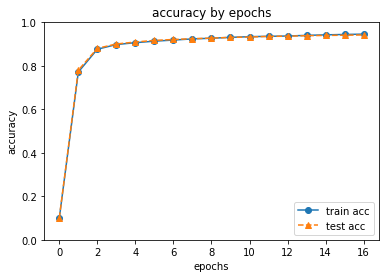

In [11]:
# グラフの描画
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc', marker='o')
plt.plot(x, test_acc_list, label='test acc', linestyle='--', marker='^')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title('accuracy by epochs')
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()